In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate();

 Activating environment at `D:\TANG Yunxi\CodingPrac\CMU_HW1\Project.toml`


In [2]:
using PyPlot

# A Falling Brick: Solving Quadratic Programs (40 pts)
In this question we'll be simulating a brick falling and sliding on ice in 2D. You will show that this problem can be formulated as a QP, which you will solve using an Augmented Lagrangian method.

## The Dynamics
The dynamics of the brick can be written in continuous time as
$$ M \dot{v}  + M g = J^T \lambda \\ \text{ where } M = mI, \; g = \begin{bmatrix} 0 \\ 9.81 \end{bmatrix},\; J = \begin{bmatrix} 0 & 1 \end{bmatrix} $$
and $\lambda \in \mathbb{R}$ is the normal force. The velocity $v \in \mathbb{R}^2$ and position $q \in \mathbb{R}^2$ are composed of the horizontal and vertical components.

We can discretize the dynamics with backward Euler:
$$ \begin{bmatrix} v_{k+1} \\ q_{k+1} \end{bmatrix} = \begin{bmatrix} v_k \\ q_k \end{bmatrix}
+ h \begin{bmatrix} \frac{1}{m} J^T \lambda_{k+1} - g \\ v_{k+1} \end{bmatrix} $$

We also have the following contact constraints:
$$ \begin{align}
J q_{k+1} &\geq 0 &&\text{(don't fall through the ice)} \\
\lambda_{k+1} &\geq 0 &&\text{(normal forces only push, not pull)} \\
\lambda_{k+1} J q_{k+1} &= 0 &&\text{(no force at a distance)}
\end{align} $$

## Part (a): QP formulation (5 pts)
Show that these discrete-time dynamics are equivalent to the following QP by writing down the KKT conditions.

$$ \begin{align}
    &\text{minimize}_{v_{k+1}} && \frac{1}{2} v_{k+1}^T M v_{k+1} + v_{k+1}^T M (hg - v_k) \\
    &\text{subject to} && J(q_k + h v_{k+1}) \ge 0 \\
\end{align} $$

**TASK**: Write down the KKT conditions for the optimization problem above, and show that it's equivalent to the dynamics problem stated previously. Use LaTeX markdown.

**SOLUTION**: \
**Solution**: \
The Lagrangian can be writted as 
$$L(v_{k+1},\lambda_{k+1}) = \frac{1}{2} v_{k+1}^T M v_{k+1} + v_{k+1}^T M (hg - v_k) - \lambda_{k+1}J(q_k + h v_{k+1})$$
We can derive its KKT conditions as below
$$ \begin{align}
    & \nabla_{v_{k+1}}L = Mv_{k+1}+M(hg-v_k)-\lambda_{k+1}hJ^{T} \\
\end{align} $$
Then full kkt is
$$ \begin{align}
     \nabla_{v_{k+1}}L &= 0 \\
     J(q_k + h v_{k+1}) &\ge 0 \\
     \lambda_{k+1} &\ge 0 \\
     \lambda_{k+1}J(q_k + h v_{k+1}) &= 0
\end{align} $$
Where $\nabla_{v_{k+1}}L = 0$ is exactly the dynamics constraint with backwork Euler. And $J(q_k + h v_{k+1}) \ge 0$ is actually $Jq_{k+1}\ge 0$. We can see discrete-time dynamics are equivalent to the QP problem.

## Part (b): Implement an Augmented Lagrangian QP solver (25 pts)
Now that we've shown that we can formulate the falling brick problem as a QP, write an augmented Lagrangian QP solver.

We've provided the following data structure for storing the problem data for a generic QP of the form:
$$ \begin{align}
    &\text{minimize}_{x} && \frac{1}{2} x^T P x + q^T x \\
    &\text{subject to} && A x = b \\
    &&& C x \leq d \\
\end{align} $$

We've also provided a handful of functions that you may find useful when implementing your augmented Lagrangian solver. You're not required to use them.

In [3]:
@show Base.size([1;2;3])
@show length([1;2;3])
add(x,y) = x + y # fast define a function
add(2,3)

Base.size([1; 2; 3]) = (3,)
length([1; 2; 3]) = 3


5

In [4]:
using Random, LinearAlgebra
"""
    QPData

Holds the data for a Quadratic Program (QP) of the following form:

min 0.5 x'P*x + q'x
st. A*x = b
    C*x ≤ d

# Constructors
    QPData(P,q,A,b,C,d)
    QPData(n::Int,m::Int,p::Int)

The second constructor will initialize all the problem with zeros of the appropriate dimension
"""
struct QPData
    P::Matrix{Float64}
    q::Vector{Float64}
    A::Matrix{Float64}
    b::Vector{Float64}
    C::Matrix{Float64}
    d::Vector{Float64}
end
function QPData(n::Int, m::Int, p::Int)
    QPData(zeros(n,n), zeros(n), zeros(m,n), zeros(m), zeros(p,n), zeros(p))
end
Base.size(qp::QPData) = (length(qp.q), num_eq(qp), num_ineq(qp))
num_eq(qp::QPData) = length(qp.b)
num_ineq(qp::QPData) = length(qp.d)

objective(qp::QPData, x) = 0.5 * x'qp.P*x + qp.q'x
ceq(qp::QPData, x) = qp.A * x - qp.b
cin(qp::QPData, x) = qp.C * x - qp.d

function primal_residual(qp::QPData, x, λ, μ)
    qp.P*x + qp.q + qp.A'λ + qp.C'μ
end

function dual_residual(qp::QPData, x, λ, μ)
    g = ceq(qp, x)
    h = cin(qp, x)
    return [g; max.(0, h)]
end

function complimentarity(qp::QPData, x, λ, μ)
    return [min.(0, μ); μ .* cin(qp, x)]
end

complimentarity (generic function with 1 method)

Implement the following function, which solves the QP specified by a `QPData` object. See the code below for an example of using the `QPData` type and how we expect it to be passed into the method. You're not requried to solve a problem with equality constraints (since the brick problem doesn't require it), but we recommended adding in the functionality so you have a fully-functioning QP solver you can use for other problems.

As we saw in class, an augmented Lagrangian solver consists of two loops: an "inner" loop that takes Newtons steps on the unconstrained augmented Lagrangian, and an "outer" loop that updates the penalty parameter and the estimates of the dual variables. We've provided you some starter code below to help you out. If you want to change those other methods (maybe to use a custom Julia type or take in extra input arguments), you're welcome to do so. We'll only call the outer `solve_qp` method from our test scripts.

In [5]:
# TASK: Implement the following method (25 pts)
"""
    solve_qp(qp::QPData, x0, [λ0, μ0]; kwargs...)

Solve the quadratic program (QP) specified by `qp::QPData`, given initial guess `x` for the primal variables, 
and optionally the Lagrange multipliers for the equality `λ` and inequality `μ` constraints.

Returns the optimized solution of primal and dual variables, `xstar,λstar,μstar`.

# Optional Keyword Arguments
* `penalty_initial` initial value of the penalty parameter
* `penalty_scaling` geometric scaling factor for the penalty updates
* `eps_primal` tolerance for primal feasiblity (constraint violation)
* `eps_inner` tolerance for inner Newton solve
* `max_iters` maximum number of outer loop iterations
"""
function solve_qp(qp::QPData, x0, λ0=zeros(num_eq(qp)), μ0=zeros(num_ineq(qp)); 
                    penalty_initial=10.0, 
                    penalty_scaling=10.0, 
                    eps_primal=1e-6,
                    eps_inner=1e-6,
                    max_iters=20
                )
    x = copy(x0)
    λ = copy(λ0)
    μ = copy(μ0)
    ρ = penalty_initial
    ϕ = penalty_scaling
    # Start outer loop
    for i = 1:max_iters
        # Solve the inner, unconstrained problem
        x = newton_solve(qp, x, λ, μ, ρ, eps_inner=eps_inner)
        
        # Use the new solution to update the dual variables
        λ, μ = dual_update(qp, x, λ, μ, ρ)
        
        # TODO: update the penalty parameter
        ρ = ϕ * ρ
        if norm(dual_residual(qp, x, λ, μ)) < eps_primal
            # Return the optimized variables
            return x, λ, μ
        end        
    end
    
    @warn "Outer loop max iterations"
    return x, λ, μ
end

"""
    ------------------- Inner Loop -------------------
    newton_solve(qp, x, λ, μ, ρ; kwargs...)

Minimize the augmented Lagranginan given the current values of the dual variables `λ` and `μ` 
and the penalty parameter `ρ`.
"""
function newton_solve(qp::QPData, x, λ, μ, ρ; eps_inner=1e-6)
    for i = 1:10
        # Compute the gradient and the Hessian of the augmented Lagrangian
        r = algrad(qp::QPData, x, λ, μ, ρ)
        if norm(r) < eps_inner
            return x
        end
        H = alhess(qp, x, λ, μ, ρ)
        Δx = -H\r
        # TODO: Compute the Newton step
        #       A line search will help with convergence, but shouldn't be necessary for 
        #       our problem since we're providing a good guess each time
        #line search
        alpha = 1
        r = algrad(qp, x, λ, μ, ρ)
        r2 = algrad(qp, x+alpha*Δx, λ, μ, ρ)
        while norm(r2) > norm(r)
            alpha = 0.8 * alpha
            r2 = algrad(qp, x+alpha*Δx, λ, μ, ρ)
        end
        x = x + alpha*Δx 
    end
    @warn "Inner solve max iterations"
    return x
end

"""
    algrad(qp, x, λ, μ, ρ)

Compute the gradient of the augmented Lagrangian, provided the QP data `qp`, penalty parameter `ρ`,
primal variables `x`, equality Lagrange multipliers `λ` and inequality Lagrange multipliers `μ`
"""
function algrad(qp::QPData, x, λ, μ,  ρ)
    # TODO: compute the gradient of the augmented Lagrangian
    # HINT: be sure to compute the active constraints!
    grad = zero(x)
    # part1 of the gradient
    grad = qp.P * x + qp.q + qp.A' * λ + ρ * qp.A' * ceq(qp, x)
    # carefully deal with inequality constraint
    numineq = num_ineq(qp::QPData)
    h = cin(qp::QPData, x)
    for i=1:numineq
        if h[i] > 0 || μ[i] > 0
            grad = grad + qp.C[i:i,:]' * μ[i] + ρ * qp.C[i:i,:]' * h[i]
        end
    end
    return grad
end

"""
    alhess(qp, x, λ, μ, ρ)

Compute the Hessian of the augmented Lagrangian, provided the QP data `qp`, penalty parameter `ρ`,
primal variables `x`, equality Lagrange multipliers `λ` and inequality Lagrange multipliers `μ`
"""
function alhess(qp::QPData, x, λ, μ,  ρ)
    # TODO: compute the Hessian of the augmented Lagrangian
    n = size(x)
#     hess = Matrix(I,n,n)
    hess = qp.P + ρ * qp.A' * qp.A
    # carefully deal with inequality constraint
    numineq = num_ineq(qp::QPData)
    h = cin(qp::QPData, x)
    for i=1:numineq
        if h[i] > 0 || μ[i] > 0
            hess = hess  + ρ * qp.C[i:i,:]' * qp.C[i:i,:]
        end
    end
    return hess
end

"""
    dual_update(qp, x, λ, μ, ρ)

Update the dual variables `λ` and `μ` give the primal variables `x`, QP data `qp` and penalty parameter `ρ`.
"""
function dual_update(qp, x, λ, μ, ρ)
    # TODO: compute the new values for λ and μ
    λnext = copy(λ)
    μnext = copy(μ)
    g = ceq(qp, x)
    h = cin(qp, x)
    λnext = λnext + ρ*g
    μnext = μnext + ρ*h
    # Keep the dual variables for the inequality constraints in the nonnegative orthant
    for i = 1:length(μ)
        μnext[i] = max(0, μnext[i])
    end
    return λnext, μnext
end

dual_update

You can use the following code to test your QP solver.

In [6]:
using Test, Random
using BenchmarkTools
Random.seed!(1)
# Setting up and solving a random QP
n,m,p = 10,0,15 
qp = QPData(n,m,p)
P = rand(n,n)
qp.P .= P'P   # make it P.S.D
qp.q .= randn(n)
qp.A .= randn(m,n)
qp.b .= randn(m)
qp.C .= randn(p,n)
qp.d .= randn(p)

# Initial guess
x = randn(n)

# Solve
xstar, λstar, μstar = solve_qp(qp, x)
# Check optimality conditions
@test norm(primal_residual(qp, xstar, λstar, μstar)) < 1e-3
@test norm(dual_residual(qp, xstar, λstar, μstar)) < 1e-6
@test norm(complimentarity(qp, xstar, λstar, μstar)) < 1e-3

# Compare with OSQP
using OSQP, SparseArrays
model = OSQP.Model()
OSQP.setup!(model, P=sparse(qp.P), q=qp.q, A=sparse([qp.A; qp.C]), l=[qp.b; fill(-Inf,p)], u=[qp.b; qp.d],
    eps_abs=1e-6, eps_rel=1e-6)
res = OSQP.solve!(model)
@test norm(res.x - xstar) < 1e-3
@test norm(res.y - [λstar; μstar]) < 1e-3

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 10, constraints m = 15
          nnz(P) + nnz(A) = 205
settings: linear system solver = qdldl,
          eps_abs = 1.0e-006, eps_rel = 1.0e-006,
          eps_prim_inf = 1.0e-004, eps_dual_inf = 1.0e-004,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter  objective    pri res    dua res    rho        time
   1 -2.2689e+001  6.97e+000  2.50e+000  1.00e-001  6.03e-005s
 100 -2.6945e+001  5.20e-007  7.72e-007  1.00e-001  1.23e-004s

status:               solved
number of it

Test Passed

## Part (c): Simulate the system (10 pts)
Use your solver from the previous question to simulate the brick for 3 seconds, from the initial condition of `q0 = [0,1]`, `v0 = [1,0]` with `h=0.01` sec and `m=1`.
Use the provided visualization code to visualize your results.

**NOTE**: If you are unable to get your QP solver to work, feel free to use OSQP to solve the QP. An example of setting up and solving a QP with OSQP is provided above.

In [7]:
# TASK: Implement the following method (2 pts)
"""
    build_qp(q, v; mass=1, h=0.01)

Build the Quadratic Program corresponding to the falling brick example of mass `mass`, 
given the 2D position `q` and velocity `v`, and the time step `h`.

Should return a `QPData` object with the correct sizes.
"""
function build_qp(q,v; mass=1, h=0.01)
    # TODO: finish the function
    P = diagm([mass,mass])
    qq = diagm([mass,mass])*([0;h*9.81] - v)
    A = Matrix{Float64}(undef,0,2)
    b = Vector{Float64}(undef,0)
    J = [0 1]
    C = -J .* h
    d = J*q 
    # Return as a QPData type
    QPData(P,qq,A,b,C,d)
end

build_qp

In [8]:
# TASK: Implement the following method (8 pts)
function simulate_brick(q0=[0,1.], v0=[1,0.]; h=0.01, T=3.0, m=1.0)
    times = range(0, T, step=h)
    qs = [zero(q0) for t in times]
    vs = [zero(v0) for t in times]
    qs[1] .= q0
    vs[1] .= v0
    
    # TODO: Simulate the brick by solving the QP
    #  TIP: remember to update your QP after each step
    for i=1:length(times)-1
        qp = build_qp(qs[i],vs[i])
        xstar, λstar, μstar = solve_qp(qp, vs[i])
        vs[i+1] = [xstar[1],xstar[2]]
        qs[i+1] = qs[i] + h * vs[i+1]
    end
    # Return the state and velocity trajectories
    return times, qs, vs
end

simulate_brick (generic function with 3 methods)

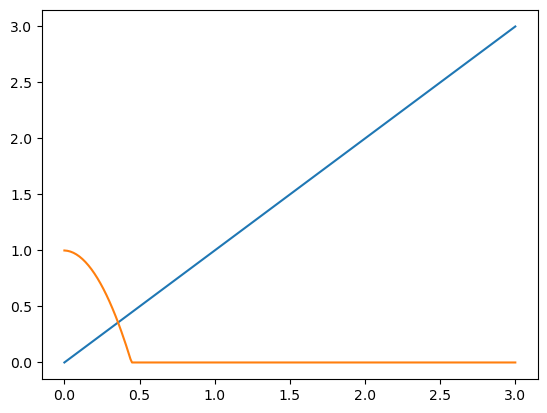

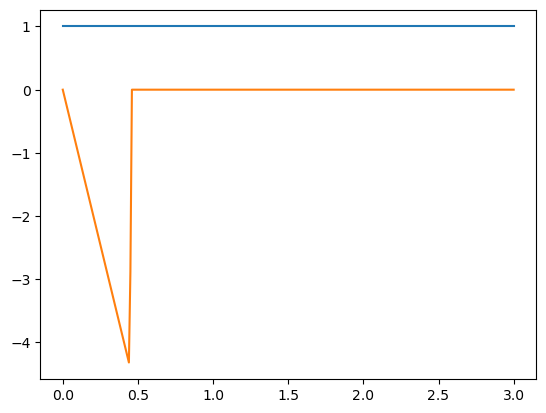

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005E652A90>
 PyObject <matplotlib.lines.Line2D object at 0x000000005E652B50>

In [12]:
times, qs, vs = simulate_brick()
figure(111)
plot(times, qs)
figure(222)
plot(times, vs)

### Visualize the Results
Use the following code to visualize the the results of your simulation

In [10]:
# Set up Visualizer
using MeshCat
using GeometryTypes, Colors, CoordinateTransformations
vis = Visualizer()
setobject!(vis["brick"], HyperRectangle(Vec(0,0,0f0), 0.5*Vec(2,1,1f0)), MeshPhongMaterial(color=colorant"firebrick"))
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://localhost:8700
└ @ MeshCat C:\Users\yxtang\.julia\packages\MeshCat\X2AUA\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("brick" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x72, 0x69, 0x63, 0x6b], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8700))

In [11]:
function show_sim(vis, qs, h)
    fps = Int(1/h)
    anim = MeshCat.Animation(fps)
    for (i,q) in enumerate(qs)
        atframe(anim, i) do
            settransform!(vis["brick"], Translation(q[1],0,q[2]))
        end
    end
    setanimation!(vis, anim)
end
show_sim(vis, h::Real) = show_sim(vis, simulate_brick(h=h)[1], h)
show_sim(vis, 0.01);

LoadError: BoundsError

## EXTRA CREDIT: Make it fast! (max 10 pts)
You can earn extra credit by making your QP solver fast. Points will be given relative to the speed of OSQP, a state-of-the-art QP solver. There will be four different levels:
1. Less than 0.5x the time of OSQP (2x slower that OSQP) (2 pts)
2. Faster than OSQP (5 pts)
3. 2x faster than OSQP (8 pts)
4. Faster than Brian's solution (about 5x faster than OSQP) (10 pts)

It will be timed on the brick simulator, see the code below for the command we will use to obtain the timing results.
Tips:
* Check out the `StaticArrays` package
* Consider making your own solver type
* Avoid allocating new memory
* Use the `BenchmarkTools` package to check the performance of individual pieces
* Check out the [Julia Performance Tips](https://docs.julialang.org/en/v1/manual/performance-tips/)
* Write a version of your simulation code that uses OSQP to compare performance

In [ ]:
# Sample timing results
using BenchmarkTools
@btime simulate_brick();